In [1]:
from pckit.comsol import ComsolModel, ComsolWorker
import pckit
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt

Using a jupyter notebook will allow you to quickly prepare and test your COMSOL model before further use

In [2]:
# Define Hashable task type
Task = namedtuple('Task', ['a', 'b'])


# Create model
class MyModel(ComsolModel):
    def pre_build(self, task: Task):
        # set parameters in Comsol model
        self.parameter(name='b', value=task.b)
        self.parameter(name='a', value=task.a)
    
    def results(self, task: Task) -> np.ndarray:
        # +0.1i[m] is for fix bug (tested only with COMSOL 5.5)
        # the error occurs only with real-valued arrays
        return np.real(self.evaluate(['freq + 0.1i', 'scat + 0.1i[m]'], unit=['Hz', 'm']))

In [3]:
# Create model, worker and solver instances

# mph options
mph_options = {
    'classkit': True,  # whether to use the “class kit” license
    'caching': True,  # If `True`, the model will be opened only once(!). Otherwise it will have to be removed from memory manually
    }
# kwargs to pass to the mph.start function
client_kwargs = {
    'cores': 2,  # you can use os.cpu_count()
    'version': '5.5',  # COMSOL version
    }

comsol_model = MyModel()
comsol_worker = ComsolWorker(
    model=comsol_model,
    filepath='acoustics_scattering.mph',
    client_kwargs=client_kwargs,
    mph_options=mph_options
    )

In [4]:
tasks = [Task(a=1, b=1), Task(a=1, b=1.25), Task(a=1, b=1.5)]
with pckit.get_solver(worker=comsol_worker) as solver:
    results = solver.solve(tasks=tasks)

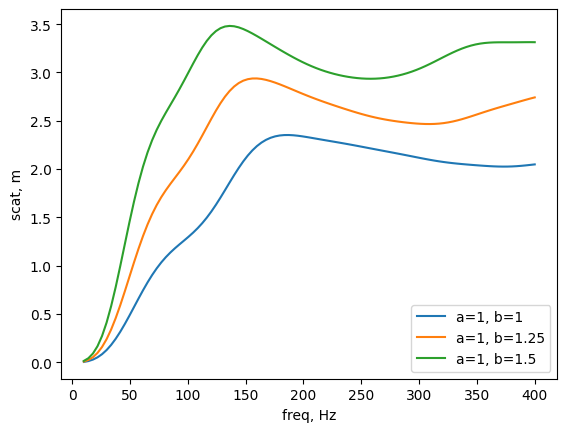

In [5]:
for result, task in zip(results, tasks):
    plt.plot(result[:, 0], result[:, 1], label=f'a={task.a}, b={task.b}')
    
plt.legend()
plt.ylabel('scat, m')
plt.xlabel('freq, Hz')
plt.show()

If you have made some changes directly to the `.mph` file, you can run the following code to remove the model from memory:

In [6]:
comsol_worker.client.remove(comsol_model)
# or you can remove all loaded models
comsol_worker.client.clear()